In [19]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

# Loading Dataset

In [2]:
stock_exchange_mk = pd.read_csv('data_mse_mse_historic_data_active.csv', sep='\t', parse_dates=['Date'])

In [3]:
df = pd.DataFrame(stock_exchange_mk)
df["stock_id"] = df["stock_id"].astype('category')
df.columns = df.columns.str.lower()

# Missing Dates

In [4]:
stocks = df.stock_id.unique()
dates_all = pd.period_range(min(df.date), max(df.date)).to_timestamp()
idx = pd.MultiIndex.from_product((dates_all, stocks), names=['date', 'stock_id'])
df_new = df.set_index(['date', 'stock_id']).reindex(idx).reset_index()

### Drop Unnecessary Dates

In [5]:
df_list = []
for stock in df.stock_id.unique():
    each_df = df[df.stock_id == stock]
    groupby_stock = each_df.groupby([pd.PeriodIndex(data=each_df.date, freq='D'), 'stock_id'])
    df_list.append(groupby_stock)

In [6]:
stock_name = []
stock_start_date = []
for i in df_list:
    name = min(i.date)[0][1]
    stock_name.append(name)
    date = min(i.date)[0][0]
    stock_start_date.append(date)
    
start_date = dict(zip(stock_name, stock_start_date))

In [7]:
start_date_df = pd.DataFrame.from_dict(start_date, orient='index', dtype='datetime64[ns]', columns=['start_date'])

In [8]:
start_date_df.head()

,start_date
ALK,1997-01-09
BESK,2002-10-10
FERS,1999-04-15
GRNT,1999-10-28
KMB,1997-05-15


In [9]:
df_clean = df_new.set_index('stock_id').join(start_date_df, lsuffix='_filter', on='stock_id').reset_index()

In [10]:
df_clean.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
1,BESK,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-10-10
2,FERS,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-15
3,GRNT,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-10-28
4,KMB,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-05-15


In [11]:
print(df_clean.shape, df_new.shape, df.shape)

(189860, 20) (189860, 19) (43441, 19)


In [12]:
df_drop = df_clean[df_clean['date'] >= df_clean['start_date']]

In [13]:
min(df_drop.date[df_drop.stock_id == 'BESK'])

Timestamp('2002-10-10 00:00:00')

### Filling NaN Values

In [14]:
df_sorted = df_drop.sort_values(by=['stock_id', 'date'], ascending=True)
test = df_sorted.drop_duplicates()
print(df_sorted.shape, test.shape)

(164754, 20) (164754, 20)


In [15]:
df_sorted.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
22,ALK,1997-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09


In [16]:
# open, high, low are fulfil with close price because there is no transaction next day
df_sorted[['open', 'high', 'low', 'close']] = df_sorted[['open', 'high', 'low', 'close']].assign(close=df_sorted['close'].ffill()).bfill(axis=1)

# quantity, volume and volume total should be 0 also because of no transactions
df_sorted[['volume', 'quantity', 'volume total']] = df_sorted[['volume', 'quantity', 'volume total']].fillna(0)

# drop adj close same as close
df_sorted = df_sorted.drop('adj close', axis=1)

In [17]:
df_sorted.head()

,stock_id,date,open,high,low,close,volume,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09


<IPython.core.display.Javascript object>


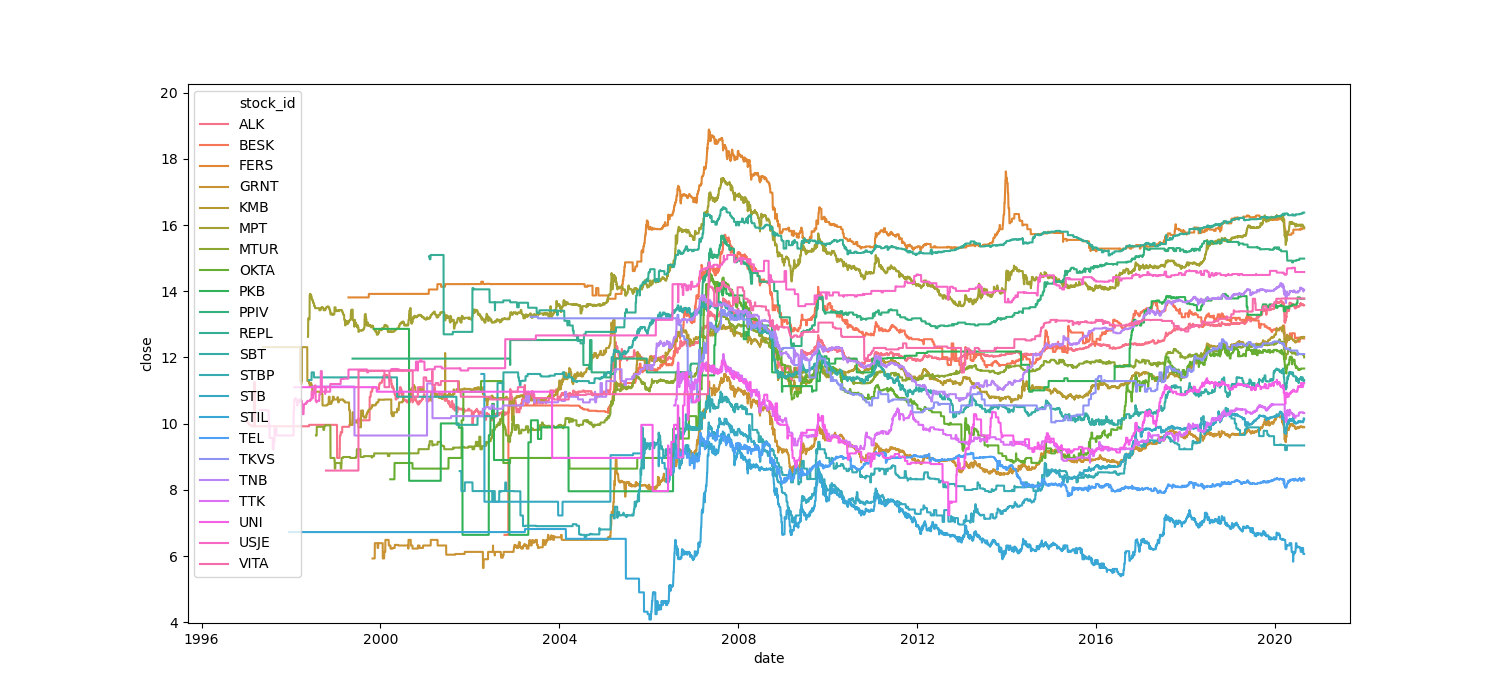

In [18]:
plt.figure(figsize=(15,7))
sns.lineplot(x="date", y=np.log2(df_sorted.close), hue="stock_id", data=df_sorted)
plt.show()

In [23]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

## feature engineering

In [24]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [44]:
df_final = df_sorted.copy()

### Date Extraction

In [45]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
df_final['sales_elapsed'] = df_final.date - df_final.start_date
df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [46]:
display_all(df_final.tail(10).T)

,189661,189683,189705,189727,189749,189771,189793,189815,189837,189859
stock_id,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA
date,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
open,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
high,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
low,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
close,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
volume,0,0,0,0,0,0,0,0,0,0
quantity,0,0,0,0,0,0,0,0,0,0
average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
change %,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


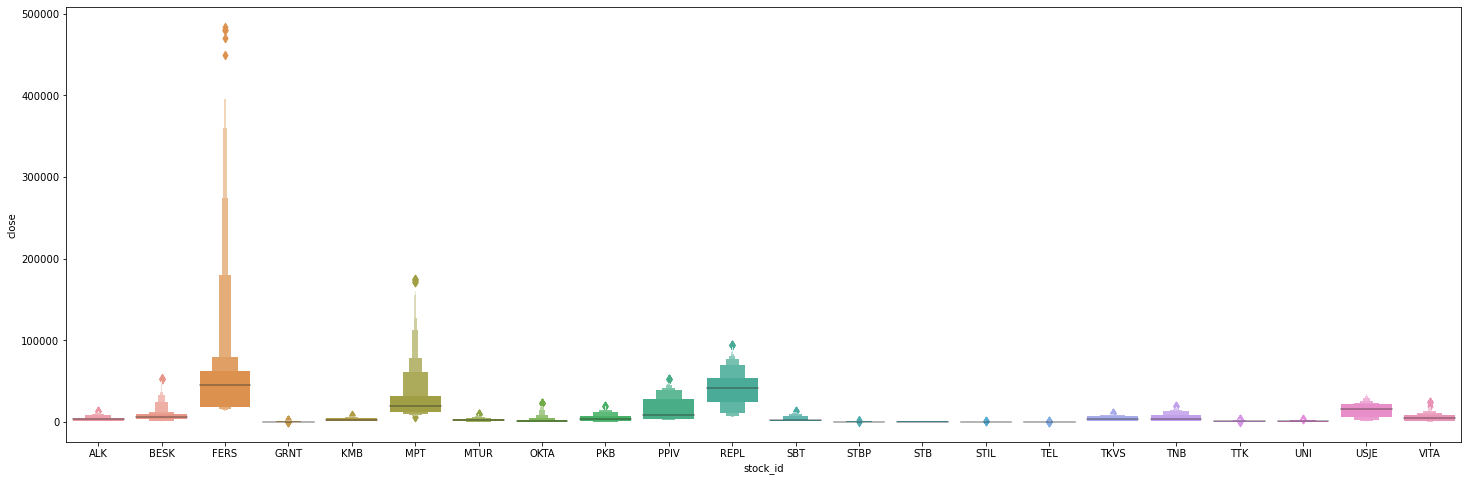

In [47]:
plt.figure(figsize=(25, 8))
sns.boxenplot('stock_id', df_sorted.close, data=df_final)
plt.show()

### rolling

In [48]:
df_final = df_final.set_index('date')

In [49]:
df_final.head(3)

,stock_id,open,high,low,close,volume,quantity,average,change %,volume total,...,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,1070.0,NaN,279270.0,...,9,False,False,False,False,False,False,31,False,0
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,...,10,False,False,False,False,False,False,31,False,1
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,0.0,0.0,NaN,NaN,0.0,...,11,False,False,False,False,False,False,31,False,2


In [199]:
#rolloing for 7 days target
sum_7_qty_by_stock = []
volumne_moving_avg_7 = []
close_moving_avg_7 = []
close_volatility_7 = []
max_7_days = []
min_7_days = []
change_by_stock_daily = []
profitability_daily = []

for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum = df_final[df_final.stock_id == stock].quantity.rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).std().shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).min()
    min_7_days.append(min_7_by_stock)
    
    # daily_change new feature
    today = df_final[df_final.stock_id == stock].close
    yesterday = today.shift()
    change_by_stock =  today / yesterday - 1
    change_by_stock_daily.append(change_by_stock)
    
    # daily_profitability new feature
    profitability_by_stock = df_final[df_final.stock_id == stock].close - df_final[df_final.stock_id == stock].open
    profitability_daily.append(profitability_by_stock)

In [200]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_2 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_2 = list(chain_object_2)

chain_object_3 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_4 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_4 = list(chain_object_4)

chain_object_5 = itertools.chain.from_iterable(max_7_days)
flattened_list_5 = list(chain_object_5)

chain_object_6 = itertools.chain.from_iterable(min_7_days)
flattened_list_6 = list(chain_object_6)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily)
flattened_list_7 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily)
flattened_list_8 = list(profitability_object)


rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1, 
                               'moving_avg_volume_7_days':flattened_list_2,
                               'moving_avg_close_7_days':flattened_list_3,
                               'volatility_7_days':flattened_list_4,
                               'max_7_days':flattened_list_5,
                               'min_7_days':flattened_list_6,
                               'change_daily':flattened_list_7,
                               'profitability_daily':flattened_list_8}
                             )

In [201]:
rolling_7_days.head(13)

,sum_7_qty_by_stock,moving_avg_volume_7_days,moving_avg_close_7_days,volatility_7_days,max_7_days,min_7_days,change_daily,profitability_daily
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,-0.018692,-20.0
6,618.0,93948.571429,1064.285714,NaN,1070.0,1050.0,0.000000,0.0
7,596.0,89220.000000,1058.571429,9.759001,1070.0,1030.0,-0.019048,-20.0
8,596.0,89220.000000,1052.857143,15.735916,1070.0,1030.0,0.000000,0.0
9,596.0,89220.000000,1047.142857,17.994708,1070.0,1030.0,0.000000,0.0
